In [40]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [41]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

In [42]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [43]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Codificador ---
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)                       # -> 64x1x1
        )
        # --- Decodificador ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),             # -> 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> 1x28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Función para añadir ruido gaussiano
def add_noise(imgs, noise_factor=0.25):
    noisy = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clamp(noisy, 0., 1.)


In [45]:
model = DenoisingAutoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

In [ ]:
outputs = []
num_epochs = 20
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        noisy_img = add_noise(img)
        recon = model(noisy_img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    scheduler.step(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, noisy_img, recon))

Epoch 1, Loss: 0.0126
Epoch 2, Loss: 0.0088
Epoch 3, Loss: 0.0066
Epoch 4, Loss: 0.0054
Epoch 5, Loss: 0.0063
Epoch 6, Loss: 0.0061
Epoch 7, Loss: 0.0051
Epoch 8, Loss: 0.0061


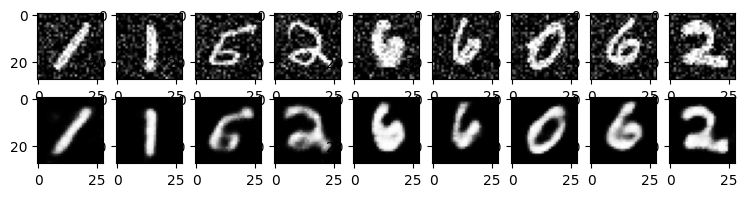

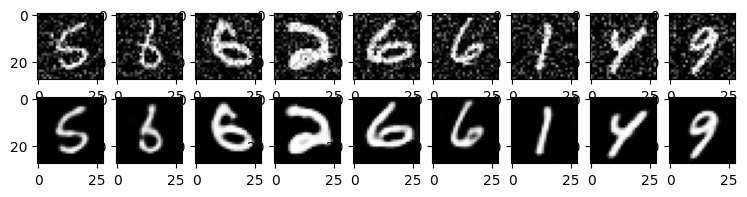

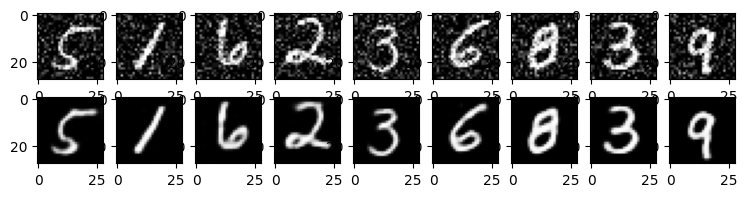

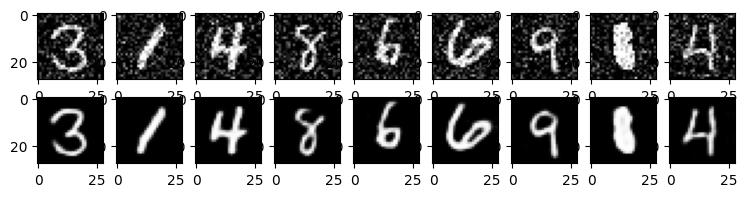

In [32]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0], cmap='gray')

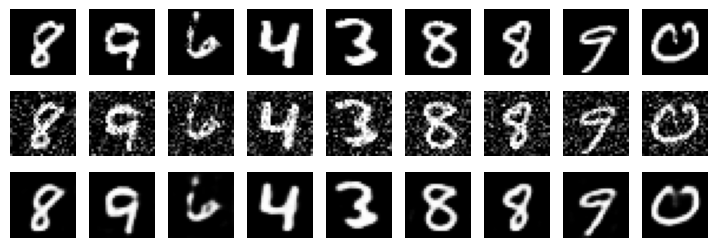

In [33]:
model.eval()
dataiter = iter(data_loader_valid)
images, _ = next(dataiter)
noisy_images = add_noise(images)

with torch.no_grad():
    outputs = model(noisy_images)

plt.figure(figsize=(9,3))
for i in range(9):
    # Original
    plt.subplot(3,9,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    # Noisy
    plt.subplot(3,9,9+i+1)
    plt.imshow(noisy_images[i][0], cmap='gray')
    plt.axis('off')
    # Reconstruido
    plt.subplot(3,9,18+i+1)
    plt.imshow(outputs[i][0], cmap='gray')
    plt.axis('off')
plt.show()
